В этом блокноте - подробное решение разобранной на семинаре 01.03 задачи о предсказании временных рядов.

Задача была технически не сложная (в том смысле, что не требуется каких-то специальных знаний), но идейно непростая, по следующим причинам:
1. Сама постановка задачи не очень чёткая, и добиться хорошего качества решения для задачи в исходной постановке сложно;
2. Мы учились предварительной работе с временными данными - анализу автокорелляций и т.д., и не делали её;
3. Мы не обсуждали валидацию моделей, предсказывающих временные ряды.

Эти (отчасти - намеренно) созданные проблемы приближают данную учебную задачу к реальной, в которой:
1. Исходная постановка часто не очень корректна и вообще всегда должна быть под сомнением;
2. Обычно нет инструкций по подготовке данных и их предварительному анализу;
3. Не всегда понятно, как оценивать качество модели.

In [2]:
# Стандартный импорт
import torch
import torch.nn as nn
import os
import sys
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

In [4]:
# Cкорректируем задачу: ежедневные данные, очевидно, имеют достаточно много шума. На данном этапе лучше работать с усреднёнными по месяцам данными.

data_path = root_path + '/data/SN_m_tot_V2.0.csv'

# Filename: SN_m_tot_V2.0.csv
# Format: Comma Separated values (adapted for import in spreadsheets)
# The separator is the semicolon ';'.

# Contents:
# Column 1-2: Gregorian calendar date
# - Year
# - Month
# Column 3: Date in fraction of year.
# Column 4: Monthly mean total sunspot number.
# Column 5: Monthly mean standard deviation of the input sunspot numbers.
# Column 6: Number of observations used to compute the monthly mean total sunspot number.
# Column 7: Definitive/provisional marker. '1' indicates that the value is definitive. '0' indicates that the value is still provisional


# Загружаем данные
sol_df = pd.read_csv(data_path,header=0,sep=';')

print(sol_df.info())
print(sol_df.isna().sum())

print(sol_df.sample(10))

# Нам понадобится только колонка "MEAN"

data = sol_df['MEAN'].to_numpy()
print(type(data))
data = torch.FloatTensor(data)
print(type(data), data.dtype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YYYY    3313 non-null   int64  
 1   MM      3313 non-null   int64  
 2   YEARF   3313 non-null   float64
 3   MEAN    3313 non-null   float64
 4   STD     3313 non-null   float64
 5   OBS     3313 non-null   int64  
 6   I       3313 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 181.3 KB
None
YYYY     0
MM       0
YEARF    0
MEAN     0
STD      0
OBS      0
I        0
dtype: int64
      YYYY  MM     YEARF   MEAN   STD   OBS  I
185   1764   6  1764.456   50.0  -1.0    -1  1
388   1781   5  1781.371  174.5  -1.0    -1  1
2079  1922   4  1922.288   18.3   4.0    30  1
789   1814  10  1814.790   32.2  -1.0    -1  1
1918  1908  11  1908.874   75.9   7.8    30  1
3268  2021   5  2021.371   21.2   5.5  1411  1
877   1822   2  1822.123    1.5   2.5    28  1
2058  1920   7  1920.540   45.7   6.0 

In [ ]:
# Сгенерируeм наборы окон из данных с помощью TimeseriesLoader()
from impls.utils import StandardScaler, TimeseriesLoader
scaler = StandardScaler()

# В этой задаче (как и в большинстве остальных) хватит сокращённой арифметики
ATYPE = torch.half
data = data.to(dtype=ATYPE)

# Размер окна и число предсказываемых наперёд точек данных
LOOKBACK = 20
FWD_SCOPE = 2

# Точка деления на тренировочную и валидационную выборки
T_SPLIT = 3000

data_train_s = scaler.fit_transform(data[:T_SPLIT])
data_val_s = scaler.transform(data[T_SPLIT:])

train_loader = TimeseriesLoader(data_train_s, lookback=LOOKBACK, fwd_scope=FWD_SCOPE, stride=1)
val_loader = TimeseriesLoader(data_val_s, lookback=LOOKBACK, fwd_scope=FWD_SCOPE, stride=1)

train_frames = [frame for frame in train_loader]
val_frames = [frame for frame in val_loader]


X_train = torch.stack([frame[0] for frame in train_frames])
y_train = torch.stack([frame[1] for frame in train_frames])

X_val = torch.stack([frame[0] for frame in val_frames])
y_val = torch.stack([frame[1] for frame in val_frames])


print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

torch.Size([2978, 20])
torch.Size([2978, 2])
torch.Size([291, 20])
torch.Size([291, 2])


In [36]:
# В класс модели сразу добавим метод для последовательных предсказаний

class SeriesPredictor(nn.Module):

    def __init__(self, lookback, scope, hidden_dim=10):

        self.scope = scope
        hidden_dim = scope
        super().__init__()
        self.L1 = nn.Linear(in_features=lookback, out_features=hidden_dim)
        self.A1 = nn.Tanh()
        self.L2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.A2 = nn.Tanh()
        self.L3 = nn.Linear(in_features=hidden_dim, out_features=scope)


    def forward(self, X):

        X = self.L1(X)
        X = self.L2(self.A1(X))
        X = self.L3(self.A2(X))
       

        return X
    

    def sequential_forward(self, x_init, fwd):

        assert x_init.shape[0] == LOOKBACK

        y_seq = torch.zeros(LOOKBACK+fwd,dtype=ATYPE)
        y_seq[0:LOOKBACK] = x_init

        with torch.no_grad():

            for t in range(0, fwd):

                y_seq[t+LOOKBACK] = self.forward(y_seq[t:t+LOOKBACK])[0]

        return y_seq[-fwd:]

## Тестируем:

lookback = 10
scope = 4
batch_size = 2

X_try = torch.randn(batch_size, lookback)
y_try = torch.randn(batch_size, scope)

model_P = SeriesPredictor(lookback=lookback, scope=scope)

# Если всё нормально, у предсказанного тензора будет градиент,
# а сам он будет иметь форму [batch_size, scope]
y_pred = model_P.forward(X_try)
print(y_pred)
print(y_pred.shape)
loss = nn.MSELoss()

print(loss(y_pred, y_try))



tensor([[-0.3234, -0.4697, -0.2933, -0.1855],
        [-0.4014, -0.4678, -0.4605, -0.4826]], grad_fn=<AddmmBackward0>)
torch.Size([2, 4])
tensor(0.8447, grad_fn=<MseLossBackward0>)


In [37]:
from IPython.display import clear_output

# Добавим отрисовку результатов во время валидации:
def validate_model(model, val, loss, loss_history, n_epochs, plot=True):

    model.eval()
  
    X_val, y_val = val

    with torch.no_grad():
        y_pred = model(X_val)
        loss_history.append(loss(y_pred, y_val))

    if plot:

        plt_t = sol_df['YEARF'][T_SPLIT:-LOOKBACK-FWD_SCOPE].to_numpy()
        t_count = len(plt_t)

        t1 = 0
        t2 = t_count

        # Задаём окна для последовательных предсказаний и их размеры
        t_seq = [0, LOOKBACK*3, LOOKBACK*6]

        tails = [t2-t1 - t for t in t_seq]
        x_seq = [X_val[t1 + t] for t in t_seq]

        y_seq = [model.sequential_forward(x, tails[i]) for i, x in enumerate(x_seq)]

        legend = ['true', 'prediction']
        for t in t_seq:
            legend.append(f'seq_pred from t={plt_t[t]}')

        # Масштабируем наши данные и предсказания 
        ys_val = scaler.inverse(y_val[:, 0])
        ys_pred = scaler.inverse(y_pred[:, 0])
        ys_seq = [scaler.inverse(y_) for y_ in y_seq]

        # Строим график функции ошибки
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

        ax1.plot(loss_history)
        ax1.grid('on')
        ax1.set_title(f'Loss on epoch {len(loss_history)-1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel(f'Loss: {loss.__name__}')
        ax1.set_xlim(0, n_epochs)
        ax1.set_ylim(0, 1.1)

        # Отрисовываем график с последовательными предсказаниями:
        ax2.plot(plt_t[t1:t2], ys_val[t1:t2])
        ax2.plot(plt_t[t1:t2], ys_pred[t1:t2])

        for i, y_ in enumerate(ys_seq):
            ax2.plot(plt_t[t_seq[i]:], y_, '--')

        ax2.grid('on')
        ax2.set_xlabel('year')
        ax2.legend(legend)

        clear_output(wait=True)
        plt.show()

In [38]:
def train_loop(model, loss, sampler, val, optimizer, n_epochs=30):
    
    loss_history = []
    
    validate_model(model, val, loss, loss_history, n_epochs)

    for epoch in tqdm(range(n_epochs)):

        batches = sampler.sample()

        for (x_b, y_b) in batches:

            model.train()
            optimizer.zero_grad()

            y_pred = model.forward(x_b)

            loss_val = loss(y_pred, y_b)
            loss_val.backward()

            optimizer.step()

        validate_model(model, val, loss, loss_history, n_epochs)            

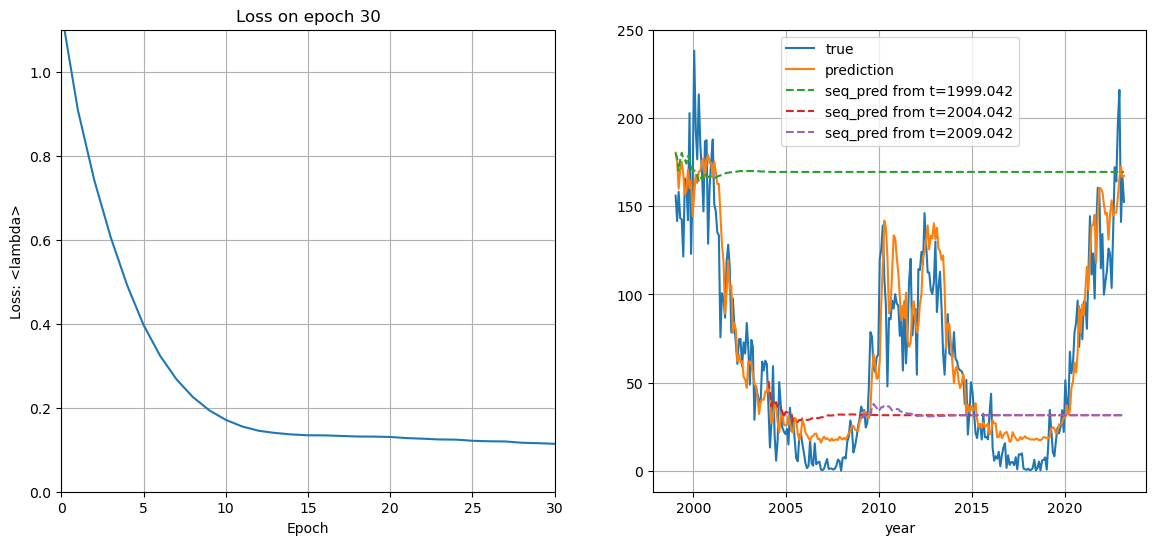

100%|██████████| 30/30 [00:47<00:00,  1.60s/it]


In [41]:
# Запускаем обучение

from impls.utils import BatchSampler

batch_size = 40
n_batches = 60

sampler = BatchSampler(X_train, y_train, batch_size=batch_size, n_batches=n_batches)

model = SeriesPredictor(lookback=LOOKBACK, scope=FWD_SCOPE, hidden_dim=6).to(dtype=ATYPE)
loss = lambda y_true, y_pred: torch.pow(y_true-y_pred, 2).mean()
opt1 = torch.optim.SGD(model.parameters(), lr=5e-3)

train_loop(model=model,
        loss=loss,
        sampler=sampler,
        val = (X_val, y_val),
        optimizer=opt1,
        n_epochs=30)

Видим, что модель способна выучить некоторые общие закономерности в данных, например, понять, что после достижения значения 50 значения скорее должны расти обычно должна идти вверх (красная и фиолетовая кривая)

Пока, как можно заметить, следя за обучением в динамике, наша модель очень склонна скатываться в локальный миниум $D_{t+1} \simeq D_{t}$

В принципе, играя с числом слоёв и их размерами, параметрами оптимизатора, функциями активации и функциями ошибки, можно этого избежать и добиться лучшего качества в данной задаче. Однако делать это вручную весьма затруднительно. На следующих занятиях мы изучим методы обучения, _систематически_ приводящие к лучшим результатам.